<a href="https://colab.research.google.com/github/cdoyle78/AlbertaCovid/blob/main/Calgary_covid_ww.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import csv
import seaborn as sns
%matplotlib inline

In [51]:
#Download covid-19 case stats from AHS webpage into data frame.

Alberta_AHS_Covid_Stats_url = 'https://www.alberta.ca/data/stats/covid-19-alberta-statistics-data.csv'

response = requests.get(Alberta_AHS_Covid_Stats_url)
print(response.status_code)
print(response.headers['content-type'])

# See https://requests.readthedocs.io/en/master/
# See https://pandas.pydata.org/docs/user_guide/io.html#io-read-csv-table
from io import StringIO
data_df_1 = pd.read_csv(StringIO(response.text))
data_df_1.head(10)

200
application/octet-stream


,Unnamed: 0,Date reported,Alberta Health Services Zone,Gender,Age group,Case status,Case type
0,1,2021-04-21,Edmonton Zone,Male,30-39 years,Recovered,Confirmed
1,2,2021-05-17,North Zone,Male,10-19 years,Recovered,Confirmed
2,3,2020-12-13,Edmonton Zone,Male,5-9 years,Recovered,Confirmed
3,4,2021-05-11,Edmonton Zone,Male,60-69 years,Recovered,Confirmed
4,5,2021-12-25,Edmonton Zone,Male,30-39 years,Recovered,Confirmed
5,6,2021-01-30,Calgary Zone,Female,1-4 years,Recovered,Confirmed
6,7,2021-09-23,South Zone,Female,80+ years,Recovered,Confirmed
7,8,2021-01-20,Edmonton Zone,Female,Under 1 year,Recovered,Confirmed
8,9,2022-01-15,Calgary Zone,Male,50-59 years,Recovered,Confirmed
9,10,2022-01-07,North Zone,Female,50-59 years,Recovered,Confirmed


In [52]:
#Isolate just Calgary Zone cases from AHS data

data_yyc = data_df_1.drop(data_df_1[data_df_1['Alberta Health Services Zone'] != 'Calgary Zone'].index)

#Rename columns, sort cases by date

data_yyc.drop('Unnamed: 0', axis = 1, inplace = True)
data_yyc.rename(columns = {'Date reported': 'Date', 'Alberta Health Services Zone':'Zone', 
                            'Gender':'Gender','Age group':'Age', 'Case status':'Status', 
                            'Case type':'Type'}, inplace = True)
data_yyc.sort_values('Date', inplace = True)

data_yyc.tail()

,Date,Zone,Gender,Age,Status,Type
149316,2022-03-01,Calgary Zone,Female,20-29 years,Active,Confirmed
205083,2022-03-01,Calgary Zone,Female,10-19 years,Active,Confirmed
171710,2022-03-01,Calgary Zone,Female,60-69 years,Active,Confirmed
245988,2022-03-01,Calgary Zone,Female,50-59 years,Active,Confirmed
196833,2022-03-01,Calgary Zone,Female,10-19 years,Active,Confirmed


In [53]:
#Create new dataframe for the number of cases each day

dly_Cases = data_yyc.groupby('Date').count()
dly_Cases.rename(columns = {'Age': 'Cases'}, inplace = True)
dly_Cases.reset_index(inplace = True)
dly_Cases = dly_Cases[['Date','Cases']]

#Add column for 7 day moving average

dly_Cases['7MA'] = dly_Cases['Cases'].rolling(window = 7, center = False).mean()

#Set 'Date' (datetime) column as index
dly_Cases['Date'] = pd.to_datetime(dly_Cases['Date'])
dly_Cases.set_index(dly_Cases['Date'], inplace = True)
dly_Cases.drop('Date',axis = 1, inplace = True)

dly_Cases.tail()



,Cases,7MA
Date,,
2022-02-25,214,193.857143
2022-02-26,122,191.000000
2022-02-27,131,188.428571
2022-02-28,143,184.857143
2022-03-01,183,173.714286


In [54]:
#Read waste water viral counts from CSV file into dataframe. 
covid_ww = pd.read_csv('covid_ww.csv')

#Rename columns as set data types
#Set 'Date' (datetime) column as index

covid_ww['Average'] = covid_ww['Average'].astype(float)
covid_ww['Date']= pd.to_datetime(covid_ww['Date'])
covid_ww.set_index(covid_ww['Date'], inplace = True)
covid_ww.drop('Date', axis = 1, inplace = True)
covid_ww.head()

,Average
Date,
2020-09-09,8.730000e+11
2020-09-21,1.370000e+12
2020-09-30,1.160000e+13
2020-10-05,2.240000e+12
2020-10-06,1.740000e+12


In [55]:
#Now that both dataframes have datetime indexes, merge dataframes with an outer join

dly_cases_ww = dly_Cases.join(covid_ww, how='outer')
dly_cases_ww.tail(20)

,Cases,7MA,Average
Date,,,
2022-02-10,579,623.571429,NaN
2022-02-11,361,553.571429,NaN
2022-02-12,310,517.000000,NaN
2022-02-13,194,482.714286,3.380000e+14
2022-02-14,353,437.571429,NaN
2022-02-15,339,375.857143,3.760000e+14
2022-02-16,369,357.857143,2.300000e+14
2022-02-17,226,307.428571,NaN
2022-02-18,256,292.428571,NaN


In [56]:
#Scale waste water values from linear regression (implied cases). 
#Uses linear regression fit for pre-Omicron data. See appendix below

dly_cases_ww['ave_scale'] = (dly_cases_ww['Average']+7.87688e+12)/3.41582084e+11
dly_cases_ww['ww_7MA'] = dly_cases_ww['ave_scale'].rolling(window = 7,min_periods=1, center = False).mean()

dly_cases_ww.tail(20)

,Cases,7MA,Average,ave_scale,ww_7MA
Date,,,,,
2022-02-10,579,623.571429,NaN,NaN,998.911329
2022-02-11,361,553.571429,NaN,NaN,998.911329
2022-02-12,310,517.000000,NaN,NaN,998.911329
2022-02-13,194,482.714286,3.380000e+14,1012.573247,942.311951
2022-02-14,353,437.571429,NaN,NaN,942.311951
2022-02-15,339,375.857143,3.760000e+14,1123.820300,1027.211017
2022-02-16,369,357.857143,2.300000e+14,696.397414,944.263654
2022-02-17,226,307.428571,NaN,NaN,944.263654
2022-02-18,256,292.428571,NaN,NaN,944.263654


[Text(0, 0.5, 'Daily Cases'), (737972.0, 738219.0), Text(0.5, 0, '')]

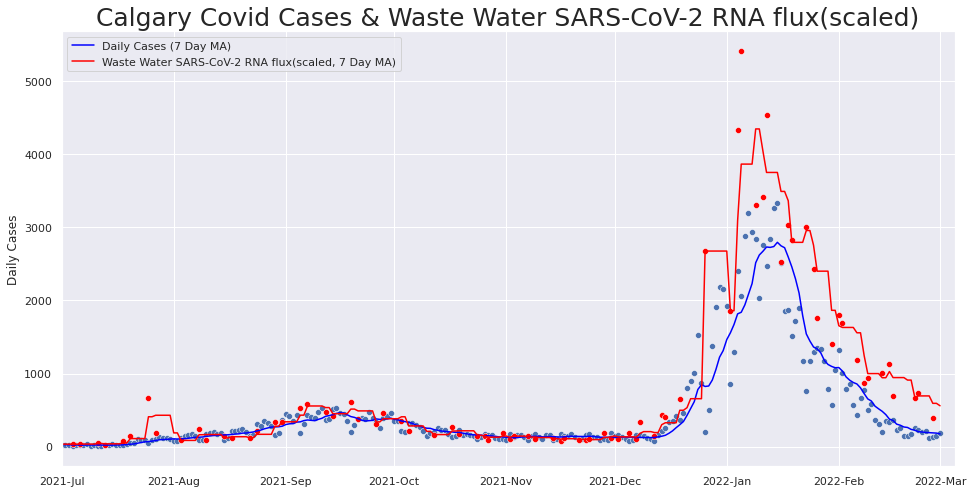

In [58]:
#Graph daily cases with 7 day moving average

sns.set(rc = {'figure.figsize':(16,8)})
#sns.set_style("whitegrid")
ax = sns.scatterplot(data = dly_cases_ww, x = 'Date', y = 'Cases')
ax = sns.lineplot(data= dly_cases_ww, x = 'Date', y = '7MA', color = 'blue')
ax = sns.lineplot(data= dly_cases_ww, x = 'Date', y = 'ww_7MA', color = 'red')
ax = sns.scatterplot(data= dly_cases_ww, x = 'Date', y = ('ave_scale'), color = 'red')
#ax.set(yscale="log")


date_form = DateFormatter("%Y-%b")
ax.xaxis.set_major_formatter(date_form)
ax.set_title("Calgary Covid Cases & Waste Water SARS-CoV-2 RNA flux(scaled)", size = 25)
ax.legend(labels = ['Daily Cases (7 Day MA)', 'Waste Water SARS-CoV-2 RNA flux(scaled, 7 Day MA)'])
ax.set(xlabel="", ylabel="Daily Cases", 
      xlim = [pd.Timestamp('2021-07-01'), pd.Timestamp('2022-03-05')])


# Appendix: Waste Water Data Fit To Pre-Omicron AHS Confirmed Case Counts

In [15]:
#Best fit is with a 2 day shift. Waste water data case counts by 2 days.

covid_ww = covid_ww.shift(periods=2, freq="D")
#covid_ww.tail(10)

In [46]:
#Drop most recent data points to fit pre-Omicron data 
#(before AHS testing was overwhelmed)

dly_cases_ww2 = dly_cases_ww.dropna()
dly_cases_ww2 = dly_cases_ww2.drop(dly_cases_ww2['2021-12-05':].index)

dly_cases_ww2.tail()

,Cases,7MA,Average,ave_scale,ww_7MA
Date,,,,,
2021-11-23,162,138.000000,2.210000e+13,87.758935,100.932928
2021-11-24,176,142.000000,2.820000e+13,105.617015,96.053672
2021-11-28,99,128.142857,5.410000e+13,181.440664,124.938871
2021-11-30,192,131.571429,3.030000e+13,111.764878,132.940852
2021-12-02,154,128.714286,2.880000e+13,107.373547,133.526363


In [30]:


#dly_cases_ww2 = dly_cases_ww2.drop(dly_cases_ww2[dly_cases_ww2['7MA'] >= 500].index)

In [47]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

#fit linear regresion model

x1 = np.array(dly_cases_ww2['Cases']).reshape(-1, 1)
y1 = np.array(dly_cases_ww2['Average']).reshape(-1, 1)

reg = LinearRegression().fit(x1,y1)
reg.score(x1,y1)

0.6729899841738126

In [48]:
#Check regression parameters

print('Coefficent', reg.coef_)
print('Intercept', reg.intercept_)
print('R^2', reg.score(x1,y1))

Coefficent [[3.26493871e+11]]
Intercept [6.30233886e+12]
R^2 0.6729899841738126


In [ ]:
#Predict 7 day moving average cases from December 26, 2021 waste water viral count from linear regression
reg.predict(np.array([[5500]]))

array([[1.87082458e+15]])

[Text(0, 0.5, 'SARS-CoV-2 RNA flux (copies/day)'),
 Text(0.5, 0, 'YYC Daily Cases 7 Day MA')]

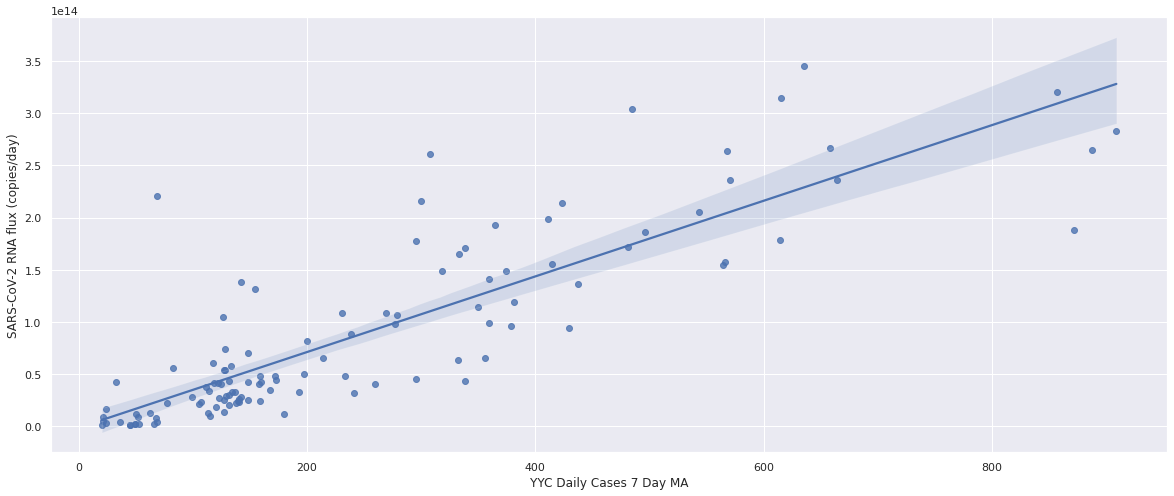

In [37]:
#Scatter plot to look at relationship between cases and viral counts in waste water.

sns.set(rc = {'figure.figsize':(20,8)})
#sns.set_style("darkgrid")
ax = sns.regplot(data = dly_cases_ww2, x = '7MA', y = 'Average')
ax.set(ylabel="SARS-CoV-2 RNA flux (copies/day)", xlabel="YYC Daily Cases 7 Day MA")
